In [ ]:
# default_exp model_functions

# Model Functions

> Endowing networkx MultiDiGraph objects with dynamics, calculating the resulting timeseries, and visualizing and analyzing the data.

In [ ]:
#hide
from nbdev import *
from nbdev.imports import *
from nbdev.export import *
from nbdev.sync import *
from nbdev.showdoc import *

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import warnings
with warnings.catch_warnings(): #ignore warnings
    warnings.simplefilter("ignore")
    import networkx as nx
    import numpy as np
    import sidis
    rng=sidis.RNG(0)
    import matplotlib.pyplot as plt
    import typing
    from typing import Optional, Tuple, Dict, Callable, Union, Mapping, Sequence, Iterable, Hashable, List, Any
    from collections import namedtuple
    import numba
    from numba import njit
    from networkm.graph_functions import *

Warming up integrator; future calls will be accelerated.
bool_integral : Elapsed time: 2.6593 seconds
bool_integral_risefall : Elapsed time: 0.0000 seconds


In [ ]:
#export
@njit
def XOR(x : List[Union[int,float]]) -> Union[int,float]:
    '''
    Arbitrary input XOR using recursiveness.
    '''
    x0=x[0]
    for x1 in x[1:]:
        and1=x0*(1-x1)
        and2=x1*(1-x0)
        x0=and1+and2-and1*and2
    return x0

In [ ]:
#export
XOR.mask=0
boolxor=XOR
smoothxor=XOR

test=XOR(np.array([1,1,1]))

In [ ]:
print(test)

1


In [ ]:
#export
@njit
def MPX(x : List[Union[int,float]]) -> Union[int,float]:
    '''
    Simply returns `x`.
    '''
    return x[0]

In [ ]:
#export
MPX.mask=1
MUX=MPX
boolmux=MPX
smoothmux=MPX

test=MPX(np.array([1]))

In [ ]:
print(test)

1


In [ ]:
#export
@njit
def NOT(x : List[Union[int,float]]) -> Union[int,float]:
    '''
    Return conjugate of `x`.
    '''
    return 1-x[0]

In [ ]:
#export
NOT.mask=2
boolnot=NOT
smoothnot=NOT

test=NOT(np.array([1]))

In [ ]:
print(test)

0


In [ ]:
#export
@njit
def COPY(x : List[Union[int,float]]) -> Union[int,float]:
    '''
    Simply returns `x`.
    '''
    return x[0]

In [ ]:
#export
COPY.mask=3
boolcopy=COPY
smoothcopy=COPY

test=COPY(np.array([1]))

In [ ]:
print(test)

1


In [ ]:
#export
@njit
def AND(x : List[Union[int,float]]) -> Union[int,float]:
    '''
    Return logical AND of `x` and `y`.
    '''
    return x[0]*x[1]

In [ ]:
#export
AND.mask=4
booland=AND
smoothand=AND

test=AND(np.array([1,1]))

In [ ]:
print(test)

1


In [ ]:
#export
@njit
def OR(x : List[Union[int,float]]) -> Union[int,float]:
    '''
    Return logical OR of `x` and `y`. See DeMorgan's Laws.
    '''
    x0,x1=x
    x0+=x1
    tmp=x0*x1
    x0-=tmp
    return x0

In [ ]:
#export
OR.mask=5
boolor=OR
smoothor=OR

test=AND(np.array([1,1]))

In [ ]:
print(test)

1


In [ ]:
#export
@njit
def BOOL(x : np.ndarray,
          mask : int = 0):
    '''
    'x': 2-D array containing list of list of args
    for the boolean function defined by `mask`. 
    '''
    y=np.zeros(x.shape[0],dtype=x.dtype)
    if mask==0:
        for i in range(x.shape[0]):
            y[i]=XOR(x[i])
    elif mask==1:
        for i in range(x.shape[0]):
            y[i]=MPX(x[i])
    elif mask==2:
        for i in range(x.shape[0]):
            y[i]=NOT(x[i])
    elif mask==3:
        for i in range(x.shape[0]):
            y[i]=COPY(x[i])
    elif mask==4:
        for i in range(x.shape[0]):
            y[i]=AND(x[i])
    elif mask==5:
        for i in range(x.shape[0]):
            y[i]=OR(x[i])
    return y

In [ ]:
#export
test=BOOL(np.array([list(s) for s in np.ndindex((2,2,2))]),mask=0)

In [ ]:
print(test)

[0 1 1 0 1 0 0 1]


In [ ]:
#export
@njit
def sigmoid(x : Union[int,float,np.ndarray],
            a : Union[int,float,np.ndarray] = np.inf):
    '''
    Sigmoid function; returns [1 + tanh( a*(x-0.5) )] / 2.
    When `a`=np.inf, mimics np.rint function.
    When `a`=0, returns constant 0.5.
    When `a`=1, returns `x`.
    When `a`>1, smoothly approaches np.rint.
    Faster than the np.rint and round functions,
    due to the order of operations on temporary variable `A`.
    Adds small value to fix edge case x=0.5 
    which otherwise returns np.nan when a=np.inf.
    '''
    A=(1+np.tanh(a*(x-0.5+0.00001)))/2
    return A

In [ ]:
#export
test=sigmoid(np.array([0.1*i for i in range(11)]))

In [ ]:
print(test)

[0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]


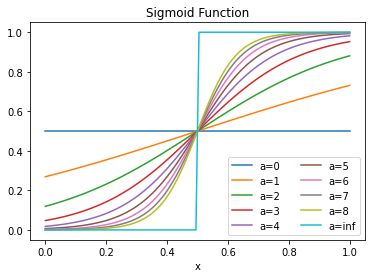

In [ ]:
for a in list(range(0,9))+[np.inf]:
    x=np.linspace(0,1,100)
    plt.plot(x,sigmoid(x=x,a=a),label=f'a={a}')
    plt.legend(loc='lower right', ncol=2)
    plt.title('Sigmoid Function')
    plt.xlabel('x')

In [ ]:
#export
def bool_model_iter(g):
    '''
    Construct a list of iterables used in the calculation
    of a delay-differential-equation (dde) for a network `g`.
    Returns a list-of-lists containing  
        [node_start,node_stop,in-degree,function-mask] 
    for each group of nodes sharing the same function.
    '''
    #make sure graph has been sorted
    try:
        sorting=g.sorting
    except:
        sort_graph(g)
        sorting=g.sorting
    
    node_funcs={n:g.nodes[n]['f'] for n in g.nodes}
    
    #group functions as {func:[list of nodes with func]}
    funcs=nx.utils.groups(sidis.cast(node_funcs,dict))
    funcs={k:list(v) for k,v in funcs.items()}
    
    #obtain index array of [first_node,last_node,in_degree,function_mask]
    itr=np.array([[n[0], #first node having function group
                 n[-1]+1, #last node +1 for indexing
                 g.in_degree(n[0]), #in-degree
                 f.mask] #mask
                  for f,n in funcs.items()]).astype(np.int64)
    return itr

In [ ]:
g=ring()
sort_graph(g)
give_nodes(g,f=NOT)
convert_edges(g,node_data=dict(f=MPX))
bool_model_iter(g)

array([[0, 3, 1, 2],
       [3, 6, 1, 1]], dtype=int64)

In [ ]:
np.array(list(node_data(g,'f').values()))

array([[CPUDispatcher(<function NOT at 0x000001F6267C49D8>),
        CPUDispatcher(<function NOT at 0x000001F6267C49D8>),
        CPUDispatcher(<function NOT at 0x000001F6267C49D8>),
        CPUDispatcher(<function MPX at 0x000001F675890438>),
        CPUDispatcher(<function MPX at 0x000001F675890438>),
        CPUDispatcher(<function MPX at 0x000001F675890438>)]],
      dtype=object)

In [ ]:
where(g,f=MPX)

[3, 4, 5]

In [ ]:
#export
def bool_initial_conditions(g,
              init : Optional[List] = None,
              hold : Optional[List] = None,
              steady : bool = True
             ):
    '''
    Parse the initial conditions of the network, including the node states
    and holding times (times for which the nodes are forced to the initial state).
    If there are multiplexer nodes, the initial conditions are applied only to these
    nodes, and the rest are allowed to freely integrate without any hold time.
    If there are not multiplexer nodes, and steady is True, 
    the initial condition is transformed according to the boolean function of each node. 
    For example, a one-node network that executes the NOT of itself would have the 
    initial condition [0] be transformed into [1]. 
    This mimics the real behavior of the network in hardware with multiplexers.
    '''
    mpx_nodes = where(g,f=MPX)
    if mpx_nodes:
        original_nodes = [i for i in g.nodes if i not in mpx_nodes]
        if init is None: #default to 1 logic high node
            init = [1]+[0 for i in mpx_nodes[1:]]

        #set original nodes to 0
        init=np.array([0 for i in original_nodes]+init)

        if hold is None: #default to hold time of 1 for mpxs
            hold = [1 for i in mpx_nodes]

        #don't hold non-mpxs
        hold = np.array([0 for i in original_nodes]+hold)

    else: #not mpx model; need to transform challenge
        if init is None: #default to 1 node logic high
            init = [1]+[0 for i in range(len(g)-1)]
        
        if steady:
            #transform init by evaluating boolean func
            init=np.array([g.nodes[n]['f'](np.array([init[j] \
              for j in list(g.predecessors(n))])) for n in g.nodes])

        #default to hold time of 1
        if hold is None: 
            hold = np.array([1 for i in g.nodes])
        else:
            hold = np.array(hold)

    return init,hold

In [ ]:
bool_initial_conditions(g)

(array([0, 0, 0, 1, 0, 0]), array([0, 0, 0, 1, 1, 1]))

In [ ]:
g_without_mpx=ring()
give_nodes(g_without_mpx,f=NOT)
bool_initial_conditions(g_without_mpx)

(array([1, 1, 0]), array([1, 1, 1]))

In [ ]:
bool_initial_conditions(g_without_mpx,steady=False)

([1, 0, 0], array([1, 1, 1]))

In [ ]:
bool_initial_conditions(g_without_mpx,init=[1,1,1],steady=False)

([1, 1, 1], array([1, 1, 1]))

In [ ]:
#export
def setup_bool_integral(g : nx.MultiDiGraph,
                   init : Optional[List[float]] = None,
                   hold : Optional[List[int]] = None,
                   T : int = 15,
                   dt : float = 0.01,
                   noise : float = 0.01,
                   steady : bool = True
                  ):
    '''
    Setup the Boolean integral with the list of initial conditions `init`
    and times to hold the nodes to those values `hold`. If `steady`, will
    transform the initial conditions to their steady-state valus using the
    dynamical functions `f`. `T`, `dt` determine the time and timestep
    of the integal. `noise` is the amplitude of noise on each node
    randomly drawn from [0,noise].
    '''
    
    iterator = bool_model_iter(g)
    T=int(T/dt)
    
    ndata=node_data(g,'delay','a','tau')
    edata=edge_data(g,'delay','a','tau')
    
    time_delays=np.array(edata['delay']).astype(np.int64)
    sigmoid_constants=np.array(ndata['a']).astype(np.float64)
    time_constants=np.array(ndata['tau']).astype(np.float64)
    predecessors=np.concatenate([list(g.predecessors(n)) for n in g.nodes]).astype(np.int64)
    
    noise=rng.random(0,noise,absval=True,shape=(T,len(g))).astype(np.float64)

    initial_conditions,hold_times=bool_initial_conditions(g,
                                                          init=init,
                                                          hold=hold,
                                                          steady=steady)
    
    hold_times=(hold_times/dt).astype(np.int64)
    time_delays=(time_delays/dt).astype(np.int64)
    
    return iterator,time_delays,sigmoid_constants,time_constants,predecessors,noise,\
        initial_conditions,hold_times

In [ ]:
g=ring()
sort_graph(g)
give_nodes(g,f=NOT,a=20,tau=1)
convert_edges(g,node_data=dict(f=MPX,tau=1,a=20))
give_edges(g,delay=0.2)
itr,delay,a,tau,pred,noise,init,hold=setup_bool_integral(g)
itr,delay,a,tau,pred,noise,init,hold

(array([[0, 3, 1, 2],
        [3, 6, 1, 1]], dtype=int64),
 array([0, 0, 0, 0, 0, 0], dtype=int64),
 array([20., 20., 20., 20., 20., 20.]),
 array([1., 1., 1., 1., 1., 1.]),
 array([4, 5, 3, 0, 1, 2], dtype=int64),
 array([[6.36961687e-03, 2.69786714e-03, 4.09735239e-04, 1.65276355e-04,
         8.13270239e-03, 9.12755577e-03],
        [6.06635776e-03, 7.29496561e-03, 5.43624991e-03, 9.35072424e-03,
         8.15853554e-03, 2.73850017e-05],
        [8.57404277e-03, 3.35855753e-04, 7.29655446e-03, 1.75655621e-03,
         8.63178922e-03, 5.41461220e-03],
        ...,
        [2.46257589e-03, 9.43285689e-03, 8.92599177e-03, 5.07851759e-03,
         9.65798888e-03, 4.81465285e-04],
        [1.07795756e-03, 2.53035914e-03, 1.26149810e-04, 9.72678230e-03,
         7.56071679e-03, 6.52382958e-03],
        [6.14774053e-03, 2.91512583e-03, 5.86452334e-03, 2.70086853e-03,
         8.78790496e-03, 8.68544836e-04]]),
 array([0, 0, 0, 1, 0, 0]),
 array([  0,   0,   0, 100, 100, 100], dtype=int64))

In [ ]:
#export
@sidis.timer
@njit
def bool_integral(iterator : np.ndarray,
                  time_delays : np.ndarray,
                  sigmoid_constants : np.ndarray,
                  time_constants : np.ndarray,
                  predecessors : np.ndarray,
                  noise : np.ndarray,
                  initial_conditions : np.ndarray,
                  hold_times : np.ndarray,
                  dt : float
             ):
    '''
    Jit accelerated integral for boolean networks.
    See `bool_integral_setup` and `bool_model_iter`. 
    Loops over time and the iterator and returns the
    node state `x` of shape (T,N) where N is number
    of nodes. Sets the `initial_conditions` explicitly 
    using `hold_times` for each node. 
    The `time_delays` and `predecessors` are arrays
    ordered by edge index in the ordered graph.
    Slices are taken and the arrays are reshaped.
    Then, the squeezed input states of each neighbor
    are applied to the logical function of each node
    using the mask lookup table defined in the Boolean
    functions themselves. The Bool func output is then
    squeezed again, and the derivative calculated
    with the Euler method.
    '''
    x=np.zeros(noise.shape).astype(np.float64)
    dx=np.zeros(x.shape[-1]).astype(np.float64)
    
    for t in range(x.shape[0]-1):
        edge_index=0
        
        #force node state to initial condition
        if t<max(hold_times):
            for n in range(x.shape[-1]):
                if hold_times[n]>=t:
                    x[t,n]=initial_conditions[n]
                    
        #loop over iterator, calculate derivative using euler
        for i in range(len(iterator)): 
            n1,n2,deg,mask=iterator[i]
            d=-time_delays[edge_index:edge_index+(n2-n1)*deg].reshape((n2-n1,deg))
            d+=t
            p=predecessors[edge_index:edge_index+(n2-n1)*deg].reshape((n2-n1,deg))
            a=sigmoid_constants[n1:n2].reshape((n2-n1,1))
            edge_index+=(n2-n1)*deg
            
            y=np.zeros((n2-n1,deg)).astype(np.float64)
            
            for k in range(n2-n1):
                for j in range(deg):
                    de=d[k,j]
                    pr=p[k,j]
                    y[k,j]=x[de,pr]
            
            y=sigmoid(x=y,a=a)
            dx[n1:n2]=BOOL(y,mask)
            dx[n1:n2]=sigmoid(dx[n1:n2],sigmoid_constants[n1:n2])
        
        dxdt=(-x[t]+dx+noise[t])/time_constants
        
        x[t+1]=x[t]+dt*dxdt
        
    return x

In [ ]:
#export
@sidis.timer
@njit
def bool_integral_risefall(iterator : np.ndarray,
                          time_delays : np.ndarray,
                          sigmoid_constants : np.ndarray,
                          time_constants : np.ndarray,
                          predecessors : np.ndarray,
                          noise : np.ndarray,
                          initial_conditions : np.ndarray,
                          hold_times : np.ndarray,
                          dt : float
                         ):
    '''
    Almost identical to `bool_integral`, with the exception
    that `time_constants` is an (N,2) vector, where N is the
    number of nodes, and the [:,0] entry is the rise-time,
    and the [:,1] entry is the fall-time. Their difference
    tau[:,1]-tau[:,0] is modulated by the sigmoid function,
    and used in the calculation of the new denominator of the
    derivative, which is of the form
        tau_rise+(tau_fall-tau_rise)*sigmoid(x)
    '''
    x=np.zeros(noise.shape).astype(np.float64)
    dx=np.zeros(x.shape[-1]).astype(np.float64)
    
    for t in range(x.shape[0]-1):
        edge_index=0
        
        #force node state to initial condition
        if t<max(hold_times):
            for n in range(x.shape[-1]):
                if hold_times[n]>=t:
                    x[t,n]=initial_conditions[n]
                    
        #loop over iterator, calculate derivative using euler
        for i in range(len(iterator)): 
            n1,n2,deg,mask=iterator[i]
            d=-time_delays[edge_index:edge_index+(n2-n1)*deg].reshape((n2-n1,deg))
            d+=t
            p=predecessors[edge_index:edge_index+(n2-n1)*deg].reshape((n2-n1,deg))
            a=sigmoid_constants[n1:n2].reshape((n2-n1,1))
            edge_index+=(n2-n1)*deg
            
            y=np.zeros((n2-n1,deg)).astype(np.float64)
            
            for k in range(n2-n1):
                for j in range(deg):
                    de=d[k,j]
                    pr=p[k,j]
                    y[k,j]=x[de,pr]
            
            y=sigmoid(x=y,a=a)
            dx[n1:n2]=BOOL(y,mask)
            dx[n1:n2]=sigmoid(dx[n1:n2],sigmoid_constants[n1:n2])
        
        tau=time_constants[:,0]+(time_constants[:,1]-time_constants[:,0])*sigmoid(x[t],
                                                                          sigmoid_constants)
        dxdt=(-x[t]+dx+noise[t])/tau
        
        x[t+1]=x[t]+dt*dxdt
        
    return x

In [ ]:
#export
def plot_graph(g,x,dt):
    '''
    Make separate plots of the node states `x` for each in-degree grouping.
    '''
    node_funcs={n:g.nodes[n]['f'] for n in g.nodes}
    funcs=nx.utils.groups(sidis.cast(node_funcs,dict))
    funcs={k:list(v) for k,v in funcs.items()}
    for f,nodes in funcs.items():
        for i in nodes:
            plt.plot(np.arange(x.shape[0])*dt,x[:,i])
            title=f'{f.__name__} Nodes: {nodes[0]} to {nodes[-1]}'
            plt.title(title)
            plt.xlabel('Time (ns)')
            plt.ylabel('Amplitude')
        plt.show()

In [ ]:
#export
def bool_model( g,
         T : int = 15,
         dt : float = 0.01,
         noise :float = 0,
         init : List[float] = None,
         hold : List[int] = None,

         a : Union[float,Tuple[callable,float,float]] = (rng.normal,20,0),
         tau : Union[np.ndarray,Tuple[callable,np.ndarray,np.ndarray]] = (rng.normal,0.5,0),
         f : callable = XOR,

         delay : Union[float,Tuple[callable,float,float]] = (rng.random,0,0),

         edge_replacements = dict(
             lengths = 1,
             delay = (rng.normal,0,0),
             node_attrs = dict(
                 a = (rng.normal,20,0),
                 tau = (rng.normal,0.2,0),
                 f = MPX
             ),
             label = lambda g,node,iterable : len(g)+iterable
         ),
               
        plot : bool = True,
        steady : bool = True):
    
        '''
        Model the dynamics of the graph `g` by giving the node attributes
        
            f : logical function
            
            a : sigmoid function
            
            tau : time constant
            
        and edge attributes
        
            delay : time-delay
            
        and parses each of these arguments if given as a tuple of a 
        
        randomization function and its args; see `parse_kwargs`.
        
        Converts any edges with the given `edge_replacements` (see 
        
        `convert_edges` function for arguments); useful for `MPX`. 
        
        Sorts the graph in place using `sort_graph` in order to produce
        
        an iterable with `bool_model_iter`. See also `setup_bool_integral`.
        
        Initializes the dynamics to `init` using the hold times `hold`;
        
        see `bool_initial_conditions`. Integrates with `bool_integral`
        
        and `bool_integral_risefall` if `tau` is given as an array of
        
        [rise_time,fall_time]. Returns the node state array `x` 
        
        and optionally plots the resulting dynamics with `plot_graph`.
        
        '''
        
        #give node/edge attrs
        give_nodes(g,f=f,a=a,tau=tau)
        give_edges(g,delay=delay)
        
        #convert edges to new nodes
        if edge_replacements:
            convert_edges(g,edges=edge_replacements.get('edges'),
                               lengths=edge_replacements.get('lengths'),
                               node_data=edge_replacements.get('node_attrs'),
                               delay=edge_replacements.get('delay'))
        
        
        #save new data
        nodedata=node_data(g,'f','a','tau')
        edgedata=edge_data(g,'delay')
        
        #sort graph
        sort_graph(g,relabel=True)
        
    
        #setup integral
        itr,delay,a,tau,pred,noise,init,hold=setup_bool_integral(g,
                                             init=init,
                                             hold=hold,
                                             T=T,dt=dt,noise=noise,steady=steady)

        if len(tau.shape)==1:
            x=bool_integral(iterator=itr,
                          time_delays=delay,
                          sigmoid_constants=a,
                          time_constants=tau,
                          predecessors=pred,
                          noise=noise,
                          initial_conditions=init,
                          hold_times=hold,dt=dt)
        else:
            x=bool_integral_risefall(iterator=itr,
                          time_delays=delay,
                          sigmoid_constants=a,
                          time_constants=tau,
                          predecessors=pred,
                          noise=noise,
                          initial_conditions=init,
                          hold_times=hold,dt=dt)
        
        #plot
        if plot:
            plot_graph(g=g,x=x,dt=dt)
        
        return x

In [ ]:
#export
print('Warming up integrator; future calls will be accelerated.')
g=ring(N=2,left=True,right=False,loop=True)
x=bool_model(g,T=0.02,tau=0,a=0,f=COPY,edge_replacements=None,plot=False)
g=None
x=None
g=ring(N=2,left=True,right=False,loop=False)
x=bool_model(g,T=0.02,f=COPY,tau=[1,1],edge_replacements=None,plot=False)
g=None
x=None

Warming up integrator; future calls will be accelerated.
bool_integral : Elapsed time: 2.5209 seconds
bool_integral_risefall : Elapsed time: 1.8595 seconds


bool_integral : Elapsed time: 0.0080 seconds


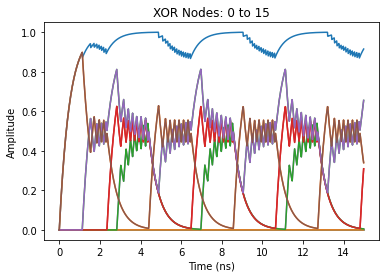

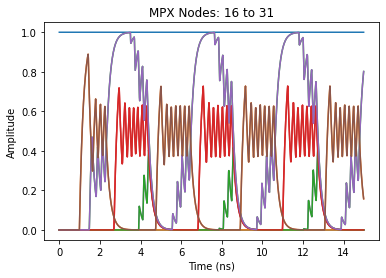

In [ ]:
g=ring(N=16,left=True,right=True,loop=True)
x=bool_model(g,T=15)

bool_integral : Elapsed time: 0.3189 seconds


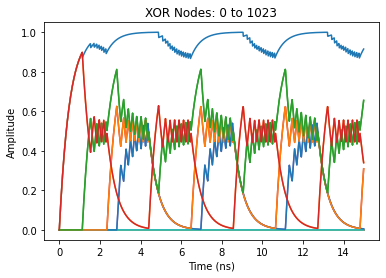

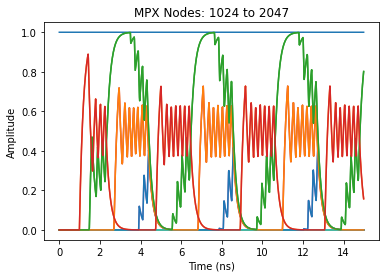

In [ ]:
g=ring(N=1024,left=True,right=True,loop=True)
x=bool_model(g,T=15,f=XOR)

bool_integral_risefall : Elapsed time: 0.0100 seconds


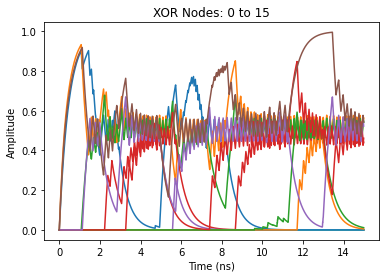

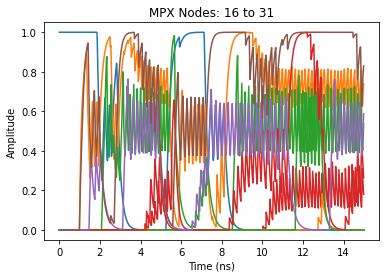

In [ ]:
x=bool_model( g=ring(N=16,left=True,right=True,loop=True),
         T = 15,
         dt = 0.01,
         noise = 0,
         init = None,
         hold = None,

         a = (rng.normal,20,0),
         tau = (rng.normal,[0.5,0.4],[0.05,0.05]),
         f = XOR,

         delay = (rng.random,0,0),

         edge_replacements = dict(
             lengths = 1,
             delay = (rng.normal,0,0),
             node_attrs = dict(
                 a = (rng.normal,20,0),
                 tau = (rng.normal,[0.2,0.15],[0.05,0.05]),
                 f = MPX
             ),
             label = lambda g,node,iterable : len(g)+iterable
         ),
        plot=True,
        steady=True
              )

In [ ]:
notebook2script()

Converted 00_graph_functions.ipynb.
Converted 01_model_functions.ipynb.
Converted 02_network_class.ipynb.
Converted index.ipynb.
